In [1]:
import torch
import torch.nn as nn

from torch.optim import Adam

c:\Users\Sanjana Rayarala\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [3]:
from torch.distributions.uniform import Uniform
from torch.utils.data import TensorDataset, DataLoader

In [4]:
import lightning as L

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Let's create embeddings for 2 simple sentences
- Troll2 is great!
- Gymkata is great!

Use one hot encoding for each input word



Troll2 [1.,0.,0.,0.]

is [0.,1.,0.,0.]

great! [0.,0.,1.,0.]

Gymkata [0.,0.,0.,1.]



inputs= torch.tensor([[1.,0.,0.,0.],

[0.,1.,0.,0.],

[0.,0.,1.,0.],

[0.,0.,0.,1.]])




labels= torch.tensor([[0.,1.,0.,0.] #troll2 predicts is

[0.,0.,1.,0.] #is predicts great

[0.,0.,0.,1.] #let's pretend it(great) predicts gymkata

[0.,1.,0.,0.]]) #gymkata predicts is

In [7]:
inputs= torch.tensor([[1.,0.,0.,0.],
[0.,1.,0.,0.],
[0.,0.,1.,0.],
[0.,0.,0.,1.]])

labels= torch.tensor([[0.,1.,0.,0.], #troll2 predicts is
[0.,0.,1.,0.], #is predicts great
[0.,0.,0.,1.], #let's pretend it(great) predicts gymkata
[0.,1.,0.,0.]]) #gymkata predicts is


dataset =TensorDataset(inputs,labels)
dataloader= DataLoader(dataset)

In [16]:
class WordEmbeddingFromScratch(L.LightningModule):
    def __init__(self):
        super().__init__()
        min_val= -0.5
        max_val= 0.5

        self.input1_w1= nn.Parameter(Uniform(min_val, max_val).sample())
        self.input1_w2= nn.Parameter(Uniform(min_val, max_val).sample())
        self.input2_w1= nn.Parameter(Uniform(min_val, max_val).sample())
        self.input2_w2= nn.Parameter(Uniform(min_val, max_val).sample())
        self.input3_w1= nn.Parameter(Uniform(min_val, max_val).sample())
        self.input3_w2= nn.Parameter(Uniform(min_val, max_val).sample())
        self.input4_w1= nn.Parameter(Uniform(min_val, max_val).sample())
        self.input4_w2= nn.Parameter(Uniform(min_val, max_val).sample())

        self.output1_w1= nn.Parameter(Uniform(min_val, max_val).sample())
        self.output1_w2= nn.Parameter(Uniform(min_val, max_val).sample())
        self.output2_w1= nn.Parameter(Uniform(min_val, max_val).sample())
        self.output2_w2= nn.Parameter(Uniform(min_val, max_val).sample())
        self.output3_w1= nn.Parameter(Uniform(min_val, max_val).sample())
        self.output3_w2= nn.Parameter(Uniform(min_val, max_val).sample())
        self.output4_w1= nn.Parameter(Uniform(min_val, max_val).sample())
        self.output4_w2= nn.Parameter(Uniform(min_val, max_val).sample())

        self.loss=nn.CrossEntropyLoss()

    def forward(self, input):
        input= input[0]
        inputs_to_top_hidden = ((input[0]* self.input1_w1)+
                                (input[1]* self.input2_w1)+
                                (input[2]* self.input3_w1)+
                                (input[3]* self.input4_w1)
        )

        inputs_to_bottom_hidden = ((input[0]* self.input1_w2)+
                                (input[1]* self.input2_w2)+
                                (input[2]* self.input3_w2)+
                                (input[3]* self.input4_w2)
        )

        output1= ((inputs_to_top_hidden * self.output1_w1)+
          (inputs_to_bottom_hidden * self.output1_w2))
        
        output2= ((inputs_to_top_hidden * self.output2_w1)+
                  (inputs_to_bottom_hidden * self.output2_w2))
        
        output3= ((inputs_to_top_hidden* self.output3_w1)+
                  (inputs_to_bottom_hidden * self.output3_w2))
        
        output4= ((inputs_to_top_hidden * self.output4_w1)+
                  (inputs_to_bottom_hidden * self.output4_w2))
        
        output_presoftmax= torch.stack([output1, output2, output3, output4]) #returns list that preserves gradients
        return output_presoftmax



    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.1)
    
    def training_step(self, batch,batch_idx):
        input_i, label_i= batch
        output_i= self.forward(input_i)
        loss= self.loss(output_i, label_i[0]) 
        return loss

In [17]:
modelFromScratch= WordEmbeddingFromScratch()

for name, param in modelFromScratch.named_parameters():
    print(name, param.data)

input1_w1 tensor(0.0545)
input1_w2 tensor(0.1691)
input2_w1 tensor(-0.3821)
input2_w2 tensor(0.0077)
input3_w1 tensor(-0.3895)
input3_w2 tensor(0.0039)
input4_w1 tensor(-0.3993)
input4_w2 tensor(-0.0841)
output1_w1 tensor(0.1147)
output1_w2 tensor(0.2444)
output2_w1 tensor(-0.3038)
output2_w2 tensor(-0.3879)
output3_w1 tensor(-0.4239)
output3_w2 tensor(0.2928)
output4_w1 tensor(0.2645)
output4_w2 tensor(0.3322)


Representing these weights in Dataframe

In [18]:
data = {
    "w1": [modelFromScratch.input1_w1.item(),
           modelFromScratch.input2_w1.item(),
           modelFromScratch.input3_w1.item(),
           modelFromScratch.input4_w1.item()],
    "w2": [modelFromScratch.input1_w2.item(),
           modelFromScratch.input2_w2.item(),
           modelFromScratch.input3_w2.item(),
           modelFromScratch.input4_w2.item()],
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"],

}

df= pd.DataFrame(data)
df

,w1,w2,token,input
0,0.054476,0.169133,Troll2,input1
1,-0.382136,0.007676,is,input2
2,-0.389508,0.003867,great,input3
3,-0.399333,-0.084088,Gymkata,input4


Troll2 and gymkata though similar, have very different weights

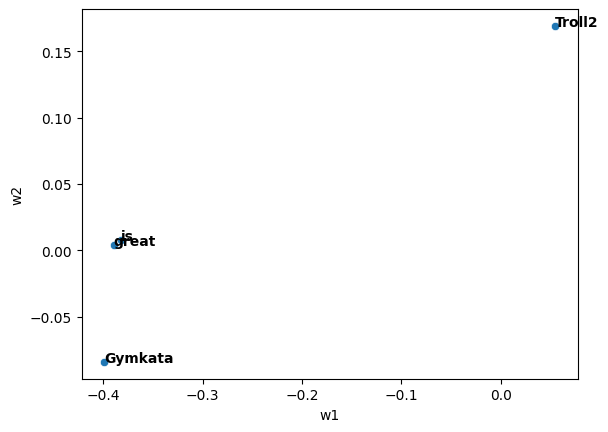

In [ ]:
sns.scatterplot(data=df, x="w1", y="w2")
plt.text(df.w1[0], df.w2[0], df.token[0], 
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')
plt.text(df.w1[1], df.w2[1], df.token[1], 
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')
plt.text(df.w1[2], df.w2[2], df.token[2], 
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')
plt.text(df.w1[3], df.w2[3], df.token[3], 
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')
plt.show()

So, let's train our embedding network

In [20]:
trainer= L.Trainer(max_epochs=100)
trainer.fit(modelFromScratch, train_dataloaders=dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | CrossEntropyLoss | 0      | train
  | other params | n/a              | 16     | n/a  
----------------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
c:\Users\Sanjana Rayarala\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\Sanjana Rayarala\AppData\Local\Programs\Python\Python310\lib\si

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [21]:
softmax= nn.Softmax(dim=0)

In [23]:
print(torch.round(softmax(modelFromScratch(torch.tensor([[1., 0., 0., 0.]]))), decimals=2))

tensor([0., 1., 0., 0.], grad_fn=<RoundBackward1>)


Input 'Troll2' gave output 'is'

In [24]:
print(torch.round(softmax(modelFromScratch(torch.tensor([[0., 1., 0., 0.]]))), decimals=2))

tensor([0., 0., 1., 0.], grad_fn=<RoundBackward1>)


In [25]:
print(torch.round(softmax(modelFromScratch(torch.tensor([[0., 0., 1., 0.]]))), decimals=2))

tensor([0., 0., 0., 1.], grad_fn=<RoundBackward1>)


In [26]:
print(torch.round(softmax(modelFromScratch(torch.tensor([[0., 0., 0., 1.]]))), decimals=2))

tensor([0., 1., 0., 0.], grad_fn=<RoundBackward1>)


Now let's automate it!!

In [27]:
class WordEmbeddingWithLinear(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.input_to_hidden= nn.Linear(4, 2, bias=False)
        self.hidden_to_output = nn.Linear(2, 4, bias=False)

        self.loss= nn.CrossEntropyLoss()

    def forward(self,input):
        hidden= self.input_to_hidden(input)
        output= self.hidden_to_output(hidden)

        return output
    
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.1)
    
    def training_step(self,batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss= self.loss(output_i, label_i)

        return loss

In [28]:
modelLinear= WordEmbeddingWithLinear()

In [29]:
data = {
    "w1": modelLinear.input_to_hidden.weight.detach()[0].numpy(),
    "w2": modelLinear.input_to_hidden.weight.detach()[1].numpy(),
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"],

}

df= pd.DataFrame(data)
df

,w1,w2,token,input
0,0.454253,-0.486728,Troll2,input1
1,-0.463321,-0.103881,is,input2
2,0.205794,0.391405,great,input3
3,0.421914,-0.362085,Gymkata,input4


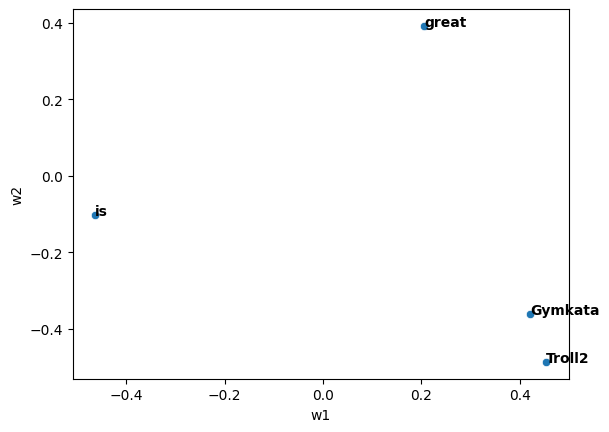

In [30]:
sns.scatterplot(data=df, x="w1", y="w2")
plt.text(df.w1[0], df.w2[0], df.token[0], 
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')
plt.text(df.w1[1], df.w2[1], df.token[1], 
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')
plt.text(df.w1[2], df.w2[2], df.token[2], 
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')
plt.text(df.w1[3], df.w2[3], df.token[3], 
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')
plt.show()

In [32]:
trainer= L.Trainer(max_epochs=100)
trainer.fit(modelLinear, train_dataloaders= dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | input_to_hidden  | Linear           | 8      | train
1 | hidden_to_output | Linear           | 8      | train
2 | loss             | CrossEntropyLoss | 0      | train
--------------------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
c:\Users\Sanjana Rayarala\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performa

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
data = {
    "w1": modelLinear.input_to_hidden.weight.detach()[0].numpy(),
    "w2": modelLinear.input_to_hidden.weight.detach()[1].numpy(),
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"],
}

df= pd.DataFrame(data)
df

,w1,w2,token,input
0,1.935485,-1.982240,Troll2,input1
1,-2.361642,1.329638,is,input2
2,1.861463,1.853266,great,input3
3,1.808075,-1.860664,Gymkata,input4


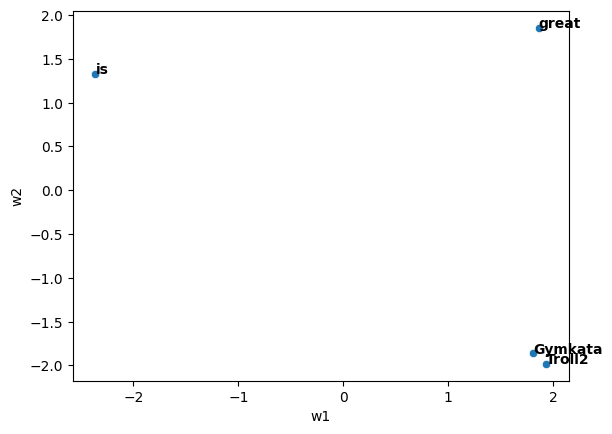

In [34]:
sns.scatterplot(data=df, x="w1", y="w2")
plt.text(df.w1[0], df.w2[0], df.token[0], 
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')
plt.text(df.w1[1], df.w2[1], df.token[1], 
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')
plt.text(df.w1[2], df.w2[2], df.token[2], 
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')
plt.text(df.w1[3], df.w2[3], df.token[3], 
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')
plt.show()

Gymkata and Troll2 got closer!!

In [35]:
word_embeddings= nn.Embedding.from_pretrained(modelLinear.input_to_hidden.weight.T)

In [36]:
word_embeddings

Embedding(4, 2)

In [37]:
word_embeddings.weight

Parameter containing:
tensor([[ 1.9355, -1.9822],
        [-2.3616,  1.3296],
        [ 1.8615,  1.8533],
        [ 1.8081, -1.8607]])

In [38]:
word_embeddings(torch.tensor(0))

tensor([ 1.9355, -1.9822])

In [39]:
vocab={'Troll2':0,
       'is':1,
       'great':2,
       'Gymkata':3
       }

word_embeddings(torch.tensor(vocab['Troll2']))

tensor([ 1.9355, -1.9822])